In [1]:
# Package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
print(os.getcwd())


C:\Users\GottaGoFaster\Documents\github_personal\test\Project_Showcase


# Data Import

In [2]:
# Load datasets
# Replace with the actual paths to your data files
dispatch_data = pd.read_csv('data/dispatch_data_with_issues.csv')
weather_data = pd.read_csv('data/weather_data_with_issues.csv')
traffic_data = pd.read_csv('data/traffic_data_with_issues.csv')


In [3]:
# Display basic info
print("Dispatch Data Info:")
print(dispatch_data.info())
print("\nWeather Data Info:")
print(weather_data.info())
print("\nTraffic Data Info:")
print(traffic_data.info())


Dispatch Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   dispatch_id    500 non-null    int64 
 1   location_id    500 non-null    int64 
 2   job_type       489 non-null    object
 3   dispatch_time  500 non-null    object
dtypes: int64(2), object(2)
memory usage: 15.8+ KB
None

Weather Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location_id    200 non-null    int64  
 1   date           200 non-null    object 
 2   temperature    189 non-null    float64
 3   precipitation  200 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 6.4+ KB
None

Traffic Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (t

In [4]:
# Preview data
print("\nDispatch Data Preview:")
print(dispatch_data.head())
print("\nWeather Data Preview:")
print(weather_data.head())
print("\nTraffic Data Preview:")
print(traffic_data.head())



Dispatch Data Preview:
   dispatch_id  location_id       job_type                  dispatch_time
0            1          139    tire_change  2024-01-01 04:47:15.766005248
1            2          129        lockout  2024-01-03 05:21:37.731175424
2            3          115         towing  2024-01-02 17:21:42.856463104
3            4          143    tire_change  2024-01-03 12:36:41.177106944
4            5          108  fuel_delivery  2024-01-01 10:03:48.860249088

Weather Data Preview:
   location_id                 date  temperature  precipitation
0          128  2024-01-02 00:00:00         91.5           2.51
1          138  2024-01-01 00:00:00         73.3           2.46
2          144  2024-01-02 00:00:00         64.5           1.06
3          126  2024-01-02 00:00:00         64.1           0.48
4          143  2024-01-01 00:00:00         75.8           0.35

Traffic Data Preview:
   location_id                 date traffic_level
0          139  2024-01-01 00:00:00          high
1 

# EDA by dataset

In [5]:
# Dispatch Data EDA:

# Identify missing values
print("Missing values in dispatch_data:")
print(dispatch_data.isnull().sum())

# Identify invalid timestamps
invalid_dispatch_time = dispatch_data[~pd.to_datetime(dispatch_data['dispatch_time'], errors='coerce').notna()]
print("\nInvalid dispatch_time rows:")
print(invalid_dispatch_time)

# Identify invalid location IDs (e.g., not in the expected range)
invalid_location_ids = dispatch_data[~dispatch_data['location_id'].between(101, 150)]
print("\nInvalid location_id rows:")
print(invalid_location_ids)

Missing values in dispatch_data:
dispatch_id       0
location_id       0
job_type         11
dispatch_time     0
dtype: int64

Invalid dispatch_time rows:
    dispatch_id  location_id     job_type dispatch_time
40           41          121  tire_change   InvalidTime

Invalid location_id rows:
    dispatch_id  location_id      job_type               dispatch_time
30           31         9999  battery_jump  2024-01-02 21:11:41.299648


In [6]:
# Traffic Data EDA

# Identify missing values
print("Missing values in traffic_data:")
print(traffic_data.isnull().sum())

# Identify invalid dates
invalid_traffic_dates = traffic_data[~pd.to_datetime(traffic_data['date'], errors='coerce').notna()]
print("\nInvalid date rows in traffic_data:")
print(invalid_traffic_dates)

# Identify invalid location IDs
invalid_traffic_location_ids = traffic_data[~traffic_data['location_id'].between(101, 150)]
print("\nInvalid location_id rows in traffic_data:")
print(invalid_traffic_location_ids)

Missing values in traffic_data:
location_id       0
date              0
traffic_level    11
dtype: int64

Invalid date rows in traffic_data:
     location_id        date traffic_level
150          113  2025-01-99      moderate

Invalid location_id rows in traffic_data:
     location_id                 date traffic_level
100       123456  2024-01-02 00:00:00      moderate


In [7]:
# Weather Data EDA:

# Identify missing values
print("Missing values in weather_data:")
print(weather_data.isnull().sum())

# Identify invalid dates
invalid_weather_dates = weather_data[~pd.to_datetime(weather_data['date'], errors='coerce').notna()]
print("\nInvalid date rows in weather_data:")
print(invalid_weather_dates)

# Identify invalid precipitation (e.g., negative values)
invalid_precipitation = weather_data[weather_data['precipitation'] < 0]
print("\nInvalid precipitation rows:")
print(invalid_precipitation)

Missing values in weather_data:
location_id       0
date              0
temperature      11
precipitation     0
dtype: int64

Invalid date rows in weather_data:
    location_id         date  temperature  precipitation
70          132  InvalidDate         67.5           1.61

Invalid precipitation rows:
    location_id                 date  temperature  precipitation
50          145  2024-01-01 00:00:00         87.5           -1.0


# Missing Data EDA/Visualization


Summary of missing data:
               dispatch_data  traffic_data  weather_data
date                     NaN           0.0           0.0
dispatch_id              0.0           NaN           NaN
dispatch_time            0.0           NaN           NaN
job_type                11.0           NaN           NaN
location_id              0.0           0.0           0.0
precipitation            NaN           NaN           0.0
temperature              NaN           NaN          11.0
traffic_level            NaN          11.0           NaN


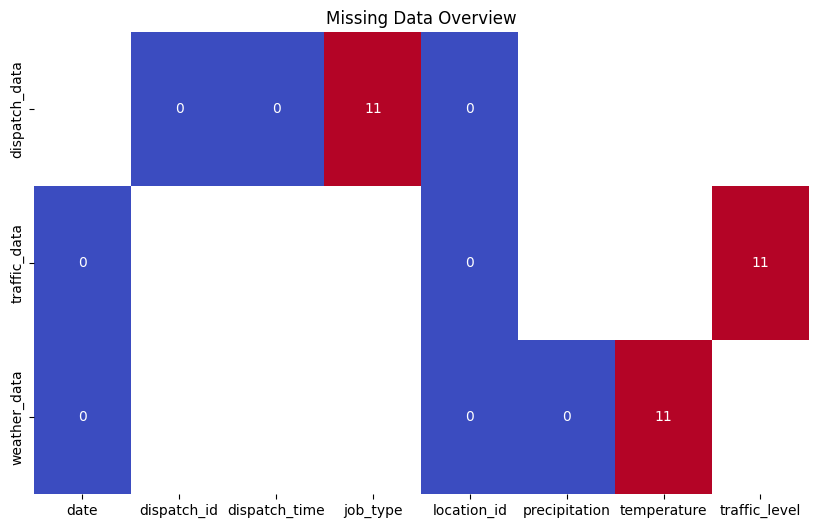

In [8]:
# Missing Data Visualization:

# Combine missing data info
missing_data = pd.DataFrame({
    "dispatch_data": dispatch_data.isnull().sum(),
    "traffic_data": traffic_data.isnull().sum(),
    "weather_data": weather_data.isnull().sum()
})
print("\nSummary of missing data:")
print(missing_data)

# Heatmap of missing values
plt.figure(figsize=(10, 6))
sns.heatmap(missing_data.T, annot=True, cmap="coolwarm", cbar=False)
plt.title("Missing Data Overview")
plt.show()


# Clean up data issues

In [9]:
# Clean up Dispatch data

# Drop rows with invalid dispatch_time
dispatch_data['dispatch_time'] = pd.to_datetime(dispatch_data['dispatch_time'], errors='coerce')
placeholder_time = pd.Timestamp("2025-01-10 12:00:00")
dispatch_data['dispatch_time'].fillna(placeholder_time, inplace=True)

# Impute invalid location_id with a placeholder (e.g., 101)
dispatch_data.loc[~dispatch_data['location_id'].between(101, 150), 'location_id'] = 101

# Simulate a completion_time column
# Assuming completion time is 5 to 60 minutes after dispatch time
dispatch_data['completion_time'] = pd.to_datetime(dispatch_data['dispatch_time']) + pd.to_timedelta(
    np.random.randint(5, 61, size=len(dispatch_data)), unit='m'
)

# Calculate delay in minutes
dispatch_data['delay_minutes'] = (
    (dispatch_data['completion_time'] - pd.to_datetime(dispatch_data['dispatch_time'])).dt.total_seconds() / 60
)

# Extract date from dispatch_time
# Convert dispatch_time to datetime and extract the date while keeping datetime64[ns]
dispatch_data['date'] = pd.to_datetime(dispatch_data['dispatch_time']).dt.floor('d')

# Preview cleaned data
print("\nCleaned dispatch_data:")
print(dispatch_data.head())


Cleaned dispatch_data:
   dispatch_id  location_id       job_type                 dispatch_time  \
0            1          139    tire_change 2024-01-01 04:47:15.766005248   
1            2          129        lockout 2024-01-03 05:21:37.731175424   
2            3          115         towing 2024-01-02 17:21:42.856463104   
3            4          143    tire_change 2024-01-03 12:36:41.177106944   
4            5          108  fuel_delivery 2024-01-01 10:03:48.860249088   

                completion_time  delay_minutes       date  
0 2024-01-01 05:45:15.766005248           58.0 2024-01-01  
1 2024-01-03 05:46:37.731175424           25.0 2024-01-03  
2 2024-01-02 17:29:42.856463104            8.0 2024-01-02  
3 2024-01-03 13:34:41.177106944           58.0 2024-01-03  
4 2024-01-01 10:52:48.860249088           49.0 2024-01-01  


In [10]:
# Clean up Traffic Data

# Drop rows with invalid dates
traffic_data['date'] = pd.to_datetime(traffic_data['date'], errors='coerce')
traffic_data = traffic_data.dropna(subset=['date'])

# Replace invalid location_id with a valid random location_id
traffic_data.loc[~traffic_data['location_id'].between(101, 150), 'location_id'] = np.random.choice(range(101, 151))

# Impute missing traffic levels with "moderate"
traffic_data['traffic_level'].fillna("moderate", inplace=True)

# Are there multiple traffic values per location-day?
print(traffic_data.groupby(['location_id', 'date']).size().reset_index(name = 'dupes').sort_values('dupes', ascending = False))
# A: Yes
# Enforce a single value per location-day
traffic_data = (
    traffic_data.groupby(['location_id', 'date'])['traffic_level']
    .agg(lambda x: x.mode().iloc[0])  # Get the mode; if there's a tie, pick the first mode
    .reset_index()
)

# Validate uniqueness, should get 1 as a result
traffic_data.groupby(['location_id', 'date']).size().reset_index(name = 'dupe_check')['dupe_check'].max() 

# Preview cleaned data
print("\nCleaned traffic_data:")
print(traffic_data.head())



    location_id       date  dupes
68          135 2024-01-01     16
65          133 2024-01-02     16
77          139 2024-01-02     13
51          126 2024-01-02     13
62          132 2024-01-01     13
..          ...        ...    ...
84          143 2024-01-01      2
81          141 2024-01-02      2
90          146 2024-01-01      1
66          134 2024-01-01      1
20          111 2024-01-01      1

[100 rows x 3 columns]

Cleaned traffic_data:
   location_id       date traffic_level
0          101 2024-01-01        severe
1          101 2024-01-02      moderate
2          102 2024-01-01           low
3          102 2024-01-02        severe
4          103 2024-01-01        severe


In [11]:
# Clean up Weather data

# Drop rows with invalid dates
weather_data['date'] = pd.to_datetime(weather_data['date'], errors='coerce')
weather_data = weather_data.dropna(subset=['date'])

# Replace invalid precipitation with 0
weather_data.loc[weather_data['precipitation'] < 0, 'precipitation'] = 0

# Impute missing temperatures with the column mean
weather_data['temperature'].fillna(weather_data['temperature'].mean(), inplace=True)

# Are there multiple weather values per location-day?
print(weather_data.groupby(['location_id', 'date']).size().reset_index(name = 'dupes').sort_values('dupes', ascending = False))
# A: Yes

# Enforce a single value per location-day
weather_data = (
    weather_data.groupby(['location_id', 'date'])
    # These fancy functions for mode are to get around the case where there's multiple modes per group - which would return a series and cause issues in the results,
    .agg(temperature=('temperature', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
         precipitation=('precipitation', lambda x: x.mode().iloc[0] if not x.mode().empty else None))
    .reset_index()
)

# Validate uniqueness, should get 1 as a result
weather_data.groupby(['location_id', 'date']).size().reset_index(name = 'dupe_check')['dupe_check'].max() 

# Preview cleaned data
print("\nCleaned weather_data:")
print(weather_data.head())


    location_id       date  dupes
73          144 2024-01-01      6
76          145 2024-01-02      5
74          144 2024-01-02      5
25          116 2024-01-01      4
65          139 2024-01-02      4
..          ...        ...    ...
11          109 2024-01-01      1
59          136 2024-01-02      1
60          137 2024-01-01      1
61          137 2024-01-02      1
56          134 2024-01-02      1

[86 rows x 3 columns]

Cleaned weather_data:
   location_id       date  temperature  precipitation
0          101 2024-01-02         62.2           1.88
1          103 2024-01-01         75.9           2.08
2          103 2024-01-02         63.0           0.82
3          104 2024-01-02         95.3           7.81
4          105 2024-01-01         66.4           0.25


# Visualize cleaned data

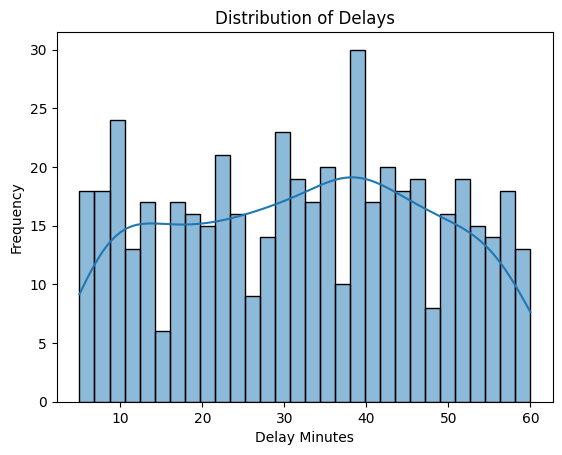

In [12]:
# EDA: Distribution of delays
sns.histplot(dispatch_data['delay_minutes'], kde=True, bins=30)
plt.title('Distribution of Delays')
plt.xlabel('Delay Minutes')
plt.ylabel('Frequency')
plt.show()

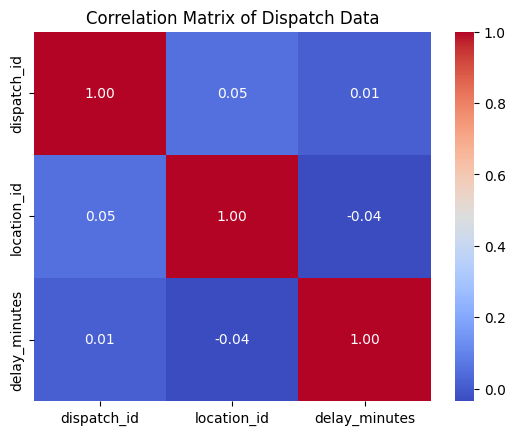

In [13]:
# Correlation heatmap for dispatch data
corr_matrix = dispatch_data.select_dtypes(include=['number']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Dispatch Data')
plt.show()

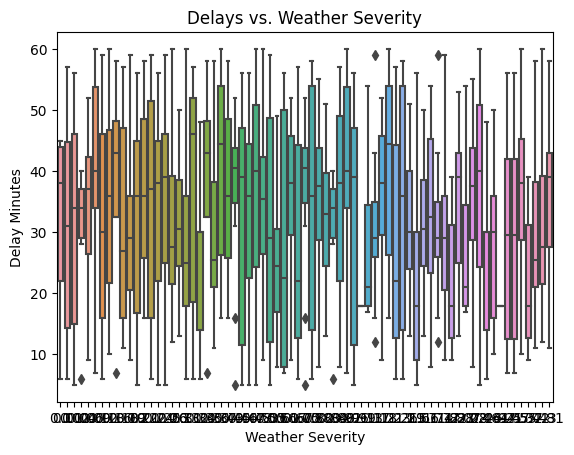

In [14]:
# EDA: Plot delays against weather severity
merged_data = pd.merge(dispatch_data, weather_data, on='location_id', how='left')
sns.boxplot(data=merged_data, x='precipitation', y='delay_minutes')
plt.title('Delays vs. Weather Severity')
plt.xlabel('Weather Severity')
plt.ylabel('Delay Minutes')
plt.show()

# Dataset Merging and EDA/Validate post-merge & filtering

In [15]:
# Add source flags
dispatch_data['source_dispatch'] = 1
traffic_data['source_traffic'] = 1
weather_data['source_weather'] = 1


In [16]:
# How unique is a location-day in the dispatch data?
dispatch_data.groupby(['location_id', 'date']).agg(rows = ('date', 'size')).reset_index().sort_values('rows', ascending = False)

,location_id,date,rows
93,133,2024-01-01,9
109,139,2024-01-01,8
114,140,2024-01-03,7
118,142,2024-01-02,7
67,124,2024-01-02,7
...,...,...,...
88,131,2024-01-02,1
70,125,2024-01-02,1
52,119,2024-01-02,1
50,118,2024-01-03,1


In [17]:
# How unique is a location-day in the traffic data?
traffic_data.groupby(['location_id', 'date']).agg(rows = ('date', 'size')).reset_index().sort_values('rows', ascending = False)

,location_id,date,rows
0,101,2024-01-01,1
63,132,2024-01-02,1
73,137,2024-01-02,1
72,137,2024-01-01,1
71,136,2024-01-02,1
...,...,...,...
30,116,2024-01-01,1
29,115,2024-01-02,1
28,115,2024-01-01,1
27,114,2024-01-02,1


In [18]:
# How unique is a location-day in the weather data?
weather_data.groupby(['location_id', 'date']).agg(rows = ('date', 'size')).reset_index().sort_values('rows', ascending = False)

,location_id,date,rows
0,101,2024-01-02,1
54,133,2024-01-02,1
62,138,2024-01-01,1
61,137,2024-01-02,1
60,137,2024-01-01,1
...,...,...,...
27,117,2024-01-01,1
26,116,2024-01-02,1
25,116,2024-01-01,1
24,115,2024-01-02,1


## Show how to analyze a full join. This type of analysis is not necessary for this project, but this is shown for completeness of analysis.

In [19]:
# Merge datasets with outer join to include all rows
merged_data = pd.merge(dispatch_data, traffic_data, on=['location_id', 'date'], how='outer')
merged_data = pd.merge(merged_data, weather_data, on=['location_id', 'date'], how='outer')

# Fill missing flags with 0 (indicating no match from that table)
merged_data['source_dispatch'] = merged_data['source_dispatch'].fillna(0)
merged_data['source_traffic'] = merged_data['source_traffic'].fillna(0)
merged_data['source_weather'] = merged_data['source_weather'].fillna(0)

# Convert flags to integers
merged_data['source_dispatch'] = merged_data['source_dispatch'].astype(int)
merged_data['source_traffic'] = merged_data['source_traffic'].astype(int)
merged_data['source_weather'] = merged_data['source_weather'].astype(int)


In [20]:
# Find only the intersection of all 3 datasets
merged_all_three = merged_data[
    (merged_data['source_dispatch'] == 1) &
    (merged_data['source_traffic'] == 1) &
    (merged_data['source_weather'] == 1)
]

percent_all_three = len(merged_all_three) / len(merged_data) * 100
print(f"Percentage of rows that merged across all three datasets: {percent_all_three:.2f}%")


Percentage of rows that merged across all three datasets: 53.45%


In [21]:
# View the full-joined data
merged_data

,dispatch_id,location_id,job_type,dispatch_time,completion_time,delay_minutes,date,source_dispatch,traffic_level,source_traffic,temperature,precipitation,source_weather
0,1.0,139,tire_change,2024-01-01 04:47:15.766005248,2024-01-01 05:45:15.766005248,58.0,2024-01-01,1,high,1,88.0,0.21,1
1,7.0,139,tire_change,2024-01-01 14:31:01.599729152,2024-01-01 15:07:01.599729152,36.0,2024-01-01,1,high,1,88.0,0.21,1
2,43.0,139,lockout,2024-01-01 02:24:51.573551104,2024-01-01 02:45:51.573551104,21.0,2024-01-01,1,high,1,88.0,0.21,1
3,153.0,139,lockout,2024-01-01 01:49:40.118000640,2024-01-01 02:17:40.118000640,28.0,2024-01-01,1,high,1,88.0,0.21,1
4,209.0,139,tire_change,2024-01-01 10:02:00.955043584,2024-01-01 10:52:00.955043584,50.0,2024-01-01,1,high,1,88.0,0.21,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,NaN,121,NaN,NaT,NaT,NaN,2024-01-02,0,high,1,75.9,1.13,1
503,NaN,134,NaN,NaT,NaT,NaN,2024-01-01,0,high,1,76.1,0.24,1
504,NaN,138,NaN,NaT,NaT,NaN,2024-01-01,0,moderate,1,73.3,2.46,1
505,NaN,143,NaN,NaT,NaT,NaN,2024-01-01,0,low,1,75.8,0.35,1


In [22]:
# Rows only in dispatch_data
only_dispatch = merged_data[
    (merged_data['source_dispatch'] == 1) &
    (merged_data['source_traffic'] == 0) &
    (merged_data['source_weather'] == 0)
]
percent_only_dispatch = len(only_dispatch) / len(dispatch_data) * 100

# Rows only in traffic_data
only_traffic = merged_data[
    (merged_data['source_dispatch'] == 0) &
    (merged_data['source_traffic'] == 1) &
    (merged_data['source_weather'] == 0)
]
percent_only_traffic = len(only_traffic) / len(traffic_data) * 100

# Rows only in weather_data
only_weather = merged_data[
    (merged_data['source_dispatch'] == 0) &
    (merged_data['source_traffic'] == 0) &
    (merged_data['source_weather'] == 1)
]
percent_only_weather = len(only_weather) / len(weather_data) * 100

# Dispatch x Traffic only
dispatch_and_traffic = merged_data[
    (merged_data['source_dispatch'] == 1) &
    (merged_data['source_traffic'] == 1) &
    (merged_data['source_weather'] == 0)
]

# Dispatch x Weather only
dispatch_and_weather = merged_data[
    (merged_data['source_dispatch'] == 1) &
    (merged_data['source_traffic'] == 0) &
    (merged_data['source_weather'] == 1)
]

# Traffic x Weather only
traffic_and_weather = merged_data[
    (merged_data['source_dispatch'] == 0) &
    (merged_data['source_traffic'] == 1) &
    (merged_data['source_weather'] == 1)
]


In [23]:
# Finda any rows from any dataset that might be missing
unmatched_rows = merged_data[
    (merged_data['source_dispatch'] == 0) &
    (merged_data['source_traffic'] == 0) &
    (merged_data['source_weather'] == 0)
]

print(f"Number of rows not matched with any dataset: {len(unmatched_rows)}")


Number of rows not matched with any dataset: 0


In [24]:
# Total rows in merged_data
total_rows = len(merged_data)

# Percentages
percent_all_three = len(merged_all_three) / total_rows * 100
percent_only_dispatch = len(only_dispatch) / len(dispatch_data) * 100
percent_only_traffic = len(only_traffic) / len(traffic_data) * 100
percent_only_weather = len(only_weather) / len(weather_data) * 100

print(f"Percentage of rows that merged across all three datasets: {percent_all_three:.2f}%")
print(f"Percentage of rows only in dispatch_data: {percent_only_dispatch:.2f}%")
print(f"Percentage of rows only in traffic_data: {percent_only_traffic:.2f}%")
print(f"Percentage of rows only in weather_data: {percent_only_weather:.2f}%")


Percentage of rows that merged across all three datasets: 53.45%
Percentage of rows only in dispatch_data: 34.80%
Percentage of rows only in traffic_data: 0.00%
Percentage of rows only in weather_data: 0.00%


In [25]:
print(dispatch_data.shape)
print(traffic_data.shape)
print(weather_data.shape)
merged_data

(500, 8)
(100, 4)
(86, 5)


,dispatch_id,location_id,job_type,dispatch_time,completion_time,delay_minutes,date,source_dispatch,traffic_level,source_traffic,temperature,precipitation,source_weather
0,1.0,139,tire_change,2024-01-01 04:47:15.766005248,2024-01-01 05:45:15.766005248,58.0,2024-01-01,1,high,1,88.0,0.21,1
1,7.0,139,tire_change,2024-01-01 14:31:01.599729152,2024-01-01 15:07:01.599729152,36.0,2024-01-01,1,high,1,88.0,0.21,1
2,43.0,139,lockout,2024-01-01 02:24:51.573551104,2024-01-01 02:45:51.573551104,21.0,2024-01-01,1,high,1,88.0,0.21,1
3,153.0,139,lockout,2024-01-01 01:49:40.118000640,2024-01-01 02:17:40.118000640,28.0,2024-01-01,1,high,1,88.0,0.21,1
4,209.0,139,tire_change,2024-01-01 10:02:00.955043584,2024-01-01 10:52:00.955043584,50.0,2024-01-01,1,high,1,88.0,0.21,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,NaN,121,NaN,NaT,NaT,NaN,2024-01-02,0,high,1,75.9,1.13,1
503,NaN,134,NaN,NaT,NaT,NaN,2024-01-01,0,high,1,76.1,0.24,1
504,NaN,138,NaN,NaT,NaT,NaN,2024-01-01,0,moderate,1,73.3,2.46,1
505,NaN,143,NaN,NaT,NaT,NaN,2024-01-01,0,low,1,75.8,0.35,1


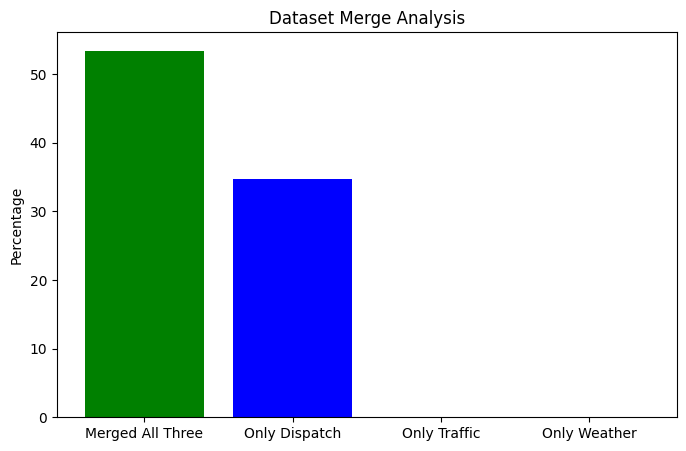

In [26]:
# Data for visualization
categories = ['Merged All Three', 'Only Dispatch', 'Only Traffic', 'Only Weather']
values = [percent_all_three, percent_only_dispatch, percent_only_traffic, percent_only_weather]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['green', 'blue', 'orange', 'red'])
plt.ylabel('Percentage')
plt.title('Dataset Merge Analysis')
plt.show()


In [27]:
# Total rows classified
total_rows_accounted_for = (
    len(merged_all_three) +s
    len(only_dispatch) +
    len(only_traffic) +
    len(only_weather) +
    len(dispatch_and_traffic) +
    len(dispatch_and_weather) +
    len(traffic_and_weather)
)

# Compare with merged_data
print(f"Total rows accounted for: {total_rows_accounted_for}")
print(f"Total rows in merged_data: {len(merged_data)}")


SyntaxError: invalid syntax. Perhaps you forgot a comma? (4236863910.py, line 3)

## Dispatch data left joining in traffic and weather for modeling

In [ ]:
# Merge datasets with outer join to include all rows
left_merged_data = pd.merge(dispatch_data, traffic_data, on=['location_id', 'date'], how='left')
left_merged_data = pd.merge(left_merged_data, weather_data, on=['location_id', 'date'], how='left')

# Fill missing flags with 0 (indicating no match from that table)
left_merged_data['source_dispatch'] = left_merged_data['source_dispatch'].fillna(0)
left_merged_data['source_traffic'] = left_merged_data['source_traffic'].fillna(0)
left_merged_data['source_weather'] = left_merged_data['source_weather'].fillna(0)

# Convert flags to integers
left_merged_data['source_dispatch'] = left_merged_data['source_dispatch'].astype(int)
left_merged_data['source_traffic'] = left_merged_data['source_traffic'].astype(int)
left_merged_data['source_weather'] = left_merged_data['source_weather'].astype(int)

left_merged_data.head()

In [ ]:
left_merged_data.groupby('dispatch_id').size().reset_index(name='count').sort_values('count', ascending = False)

In [ ]:
dispatch_data.head()
dispatch_data.groupby('dispatch_id').size().reset_index(name='count').sort_values(['count', 'dispatch_id'])
pd.merge(dispatch_data, traffic_data, on=['location_id', 'date'], how='left').groupby('dispatch_id').size().reset_index(name='count').sort_values(['dispatch_id', 'count'])
left_merged_data.groupby('dispatch_id').size().reset_index(name='count').sort_values(['dispatch_id', 'count'])
left_merged_data.shape

In [ ]:
# Data for visualization
categories = ['Merged All Three', 'Only Dispatch', 'Only Traffic', 'Only Weather']
values = [percent_all_three, percent_only_dispatch, percent_only_traffic, percent_only_weather]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['green', 'blue', 'orange', 'red'])
plt.ylabel('Percentage')
plt.title('Dataset Merge Analysis')
plt.show()


# Export for later

In [ ]:
# Save cleaned data for further analysis
dispatch_data.to_csv('data/cleaned_dispatch_data.csv', index=False)
traffic_data.to_csv('data/cleaned_traffic_data.csv', index=False)
weather_data.to_csv('data/cleaned_weather_data.csv', index=False)
